In [ ]:
#@title Copyright 2023 Google LLC. Double-click for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Colabs

Machine Learning Crash Course uses Colaboratories (Colabs) for all programming exercises. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/). For more information about Colabs and how to use them, go to [Welcome to Colaboratory](https://research.google.com/colaboratory).

# Binary classification

In this Colab, you'll complete the following tasks:
- Examine a dataset containing measurements derived from images of two species of Turkish rice.
- Create a binary classifier to sort grains of rice into the two species.
- Evaluate the performance of the model.

## Learning objectives

By completing this Colab, you'll learn:
- How to train a binary classifier.
- How to calculate metrics for a binary classifier at different thresholds.
- How to compare AUC and ROC of two different models.

## Dataset

This Colab uses the Cinar and Koklu 2019 Osmancik and Cammeo rice dataset.

Provided with a CC0 license (see [Kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik) for more documentation; lengths and area are given in pixels). Cinar and Koklu also provide datasets for multiclass (5 species of rice), pistachios, raisins, grape leaves, and so on, at their [repository](https://www.muratkoklu.com/datasets/).

### Citation

Cinar, I. and Koklu, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” *International Journal of Intelligent Systems and Applications in Engineering*, 7(3), 188-194.

DOI: https://doi.org/10.18201/ijisae.2019355381


# Load Imports

In [ ]:
# @title Load the imports

import io
import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import plotly.express as px

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

In [ ]:
# @title Load the dataset
rice_dataset_raw = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv")

Once the dataset has been loaded via the cell above, select specific columns to show summary statistics of the numerical features in the dataset.

See the Kaggle [dataset documentation](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik), especially the **Provenance** section, for explanations of what each feature means and how they were calculated.

In [ ]:
# @title
# Read and provide statistics on the dataset.
rice_dataset = rice_dataset_raw[[
    'Area',
    'Perimeter',
    'Major_Axis_Length',
    'Minor_Axis_Length',
    'Eccentricity',
    'Convex_Area',
    'Extent',
    'Class',
]]

rice_dataset.describe()

## Task 1: Describe the data

From the summary statistics above, answer the following questions:
- What are the min and max lengths (major axis length, given in pixels) of the rice grains?
- What is the range of areas between the smallest and largest rice grains?
- How many standard deviations (`std`) is the largest rice grain's perimeter from the mean?

In [22]:
# @title Solutions (run the cell to get the answers)

print(
    f'The shortest grain is {rice_dataset_raw.Major_Axis_Length.min():.1f}px long,'
    f' while the longest is {rice_dataset_raw.Major_Axis_Length.max():.1f}px.'
)
print(
    f'The smallest rice grain has an area of {rice_dataset_raw.Area.min()}px, while'
    f' the largest has an area of {rice_dataset_raw.Area.max()}px.'
)
print(
    'The largest rice grain, with a perimeter of'
    f' {rice_dataset_raw.Perimeter.max():.1f}px, is'
    f' ~{(rice_dataset_raw.Perimeter.max() - rice_dataset_raw.Perimeter.mean())/rice_dataset_raw.Perimeter.std():.1f} standard'
    f' deviations ({rice_dataset_raw.Perimeter.std():.1f}) from the mean'
    f' ({rice_dataset_raw.Perimeter.mean():.1f}px).'
)
print(
    f'This is calculated as: ({rice_dataset_raw.Perimeter.max():.1f} -'
    f' {rice_dataset_raw.Perimeter.mean():.1f})/{rice_dataset_raw.Perimeter.std():.1f} ='
    f' {(rice_dataset_raw.Perimeter.max() - rice_dataset_raw.Perimeter.mean())/rice_dataset_raw.Perimeter.std():.1f}'
)

The shortest grain is 145.3px long, while the longest is 239.0px.
The smallest rice grain has an area of 7551px, while the largest has an area of 18913px.
The largest rice grain, with a perimeter of 548.4px, is ~2.6 standard deviations (35.6) from the mean (454.2px).
This is calculated as: (548.4 - 454.2)/35.6 = 2.6


# Explore the dataset

Plot some of the features against each other, including in 3D.


In [ ]:
# Create five 2D plots of the features against each other, color-coded by class.
for x_axis_data, y_axis_data in [
    ('Area', 'Eccentricity'),
    ('Convex_Area', 'Perimeter'),
    ('Major_Axis_Length', 'Minor_Axis_Length'),
    ('Perimeter', 'Extent'),
    ('Eccentricity', 'Major_Axis_Length'),
]:
  px.scatter(rice_dataset, x=x_axis_data, y=y_axis_data, color='Class').show()

## Task 2: Visualize samples in 3D

Try graphing three of the features in 3D against each other.

In [ ]:
#@title Plot three features in 3D by entering their names and running this cell

x_axis_data = 'Enter a feature name here'  # @param {type: "string"}
y_axis_data = 'Enter a feature name here'  # @param {type: "string"}
z_axis_data = 'Enter a feature name here'  # @param {type: "string"}

px.scatter_3d(
    rice_dataset,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color='Class',
).show()

In [ ]:
# @title One possible solution

# Plot major and minor axis length and eccentricity, with observations
# color-coded by class.
px.scatter_3d(
    rice_dataset,
    x='Eccentricity',
    y='Area',
    z='Major_Axis_Length',
    color='Class',
).show()

If we were to pick three features, it seems that major axis length, area, and eccentricity might contain most of the information that differentiates the two classes. Other combinations may work as well.

Run the previous code cell to graph those three features if you haven't already.

It seems like a distinct class boundary appears in the plane of these three features. We'll train a model on just these features, then another model on the complete set of features, and compare their performance.

## Normalize data

When creating a model with multiple features, the values of each feature should span roughly the same range.  If one feature's values range from 500 to 100,000 and another feature's values range from 2 to 12, the model will need to have weights of extremely low or extremely high values to be able to combine these features effectively. This could result in a low quality model.  To avoid this,
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model.

This can be done by converting each raw value to its Z-score. The **Z-score** for a given value is how many standard deviations away from the mean the value is.

Consider a feature with a mean of 60 and a standard deviation of 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

Now normalize the numerical values in the rice dataset by converting them to Z-scores.

In [ ]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

feature_mean = rice_dataset.mean(numeric_only=True)
feature_std = rice_dataset.std(numeric_only=True)
numerical_features = rice_dataset.select_dtypes('number').columns
normalized_dataset = (
    rice_dataset[numerical_features] - feature_mean
) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Class'] = rice_dataset['Class']

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
normalized_dataset.head()

# Set the random seeds

To make experiments reproducible, we set the seed of the random number generators. This means that the order in which the data is shuffled, the values of the random weight initializations, etc, will all be the same each time the colab is run.

In [ ]:
keras.utils.set_random_seed(42)

## Label and split data

To train the model, we'll arbritrarily assign the Cammeo species a label of '1' and the Osmancik species a label of '0'.

In [23]:
# Create a column setting the Cammeo label to '1' and the Osmancik label to '0'
# then show 10 randomly selected rows.
normalized_dataset['Class_Bool'] = (
    # Returns true if class is Cammeo, and false if class is Osmancik
    normalized_dataset['Class'] == 'Cammeo'
).astype(int)
normalized_dataset.sample(10)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
3152,-0.1,0.0,-0.1,0.0,-0.0,-0.1,-1.2,Osmancik,0
207,2.6,2.6,2.8,1.2,1.6,2.6,-1.2,Cammeo,1
2625,-0.9,-1.0,-1.0,-0.4,-0.8,-0.9,1.4,Osmancik,0
1487,0.5,0.5,0.5,0.3,0.4,0.5,1.2,Cammeo,1
2751,-0.5,-0.7,-1.0,0.5,-1.7,-0.6,-1.0,Osmancik,0
1738,-1.1,-1.1,-0.7,-1.3,0.4,-1.1,1.8,Osmancik,0
2178,-0.1,-0.1,-0.3,0.3,-0.4,-0.1,-1.0,Osmancik,0
1649,0.2,0.3,0.3,-0.0,0.5,0.2,1.5,Osmancik,0
696,1.2,0.5,0.2,2.0,-1.2,1.2,-0.4,Cammeo,1
2761,-1.0,-1.1,-1.0,-0.7,-0.5,-1.0,-0.7,Osmancik,0


We can then randomize and partition the dataset into train, test, and validation splits, consisting of 80%, 10%, and 10% of the dataset respectively.

In [26]:
# Create indices at the 80th and 90th percentiles
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

# Show the first five rows of the last split
validation_data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
640,0.9,0.8,0.6,1.1,-0.1,0.9,1.7,Cammeo,1
966,0.8,0.9,1.1,0.1,1.0,0.8,1.7,Cammeo,1
1600,1.2,1.5,1.7,0.1,1.5,1.2,0.3,Cammeo,1
3,0.3,0.1,0.3,0.2,0.2,0.2,-0.3,Cammeo,1
831,0.8,0.6,0.5,0.9,-0.1,0.8,0.2,Cammeo,1


It's important to prevent the model from getting the label as input during training, which is called label leakage. This can be done by storing features and labels as separate variables.

In [27]:
label_columns = ['Class', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

## Train the model

### Choose the input features

To start with, we'll train a model on `Eccentricity`, `Major_Axis_Length,` and `Area`.

In [ ]:
# Name of the features we'll train our model on.
input_features = [
    'Eccentricity',
    'Major_Axis_Length',
    'Area',
]

## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(inputs, learning_rate, metrics)`, which defines the model's architecture.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Note: create_model applies the sigmoid function to perform [logistic regression](https://developers.google.com/machine-learning/crash-course/logistic-regression).

We also define two helpful data structures: `ExperimentSettings` and `Experiment`. We use these simple classes to keep track of our experiments, allowing us to know what hyperparameters were used and what the results were. In `ExperimentSettings`, we store all values describing an experiment (i.e., hyperparameters). Then, we store the results of a training run (i.e., the model and the training metrics) into an `Experiment` instance, along with the `ExperimentSettings` used for that experiment.

In [28]:
# @title Define the functions that create and train a model.

import dataclasses


@dataclasses.dataclass()
class ExperimentSettings:
  """Lists the hyperparameters and input features used to train am model."""

  learning_rate: float
  number_epochs: int
  batch_size: int
  classification_threshold: float
  input_features: list[str]


@dataclasses.dataclass()
class Experiment:
  """Stores the settings used for a training run and the resulting model."""

  name: str
  settings: ExperimentSettings
  model: keras.Model
  epochs: np.ndarray
  metrics_history: keras.callbacks.History

  def get_final_metric_value(self, metric_name: str) -> float:
    """Gets the final value of the given metric for this experiment."""
    if metric_name not in self.metrics_history:
      raise ValueError(
          f'Unknown metric {metric_name}: available metrics are'
          f' {list(self.metrics_history.columns)}'
      )
    return self.metrics_history[metric_name].iloc[-1]


def create_model(
    settings: ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple classification model."""
  model_inputs = [
      keras.Input(name=feature, shape=(1,))
      for feature in settings.input_features
  ]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  dense = keras.layers.Dense(
      units=1, input_shape=(1,), name='dense_layer', activation=keras.activations.sigmoid
  )
  model_output = dense(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)
  # Call the compile method to transform the layers into a model that
  # Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ExperimentSettings,
) -> Experiment:
  """Feed a dataset into the model in order to train it."""

  # The x parameter of keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.
  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )


print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


## Define a plotting function

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) function plots one or more curves, showing how various classification metrics change with each epoch.

In [29]:
# @title Define the plotting function.
def plot_experiment_metrics(experiment: Experiment, metrics: list[str]):
  """Plot a curve of one or more metrics for different epochs."""
  plt.figure(figsize=(12, 8))

  for metric in metrics:
    plt.plot(
        experiment.epochs, experiment.metrics_history[metric], label=metric
    )

  plt.xlabel("Epoch")
  plt.ylabel("Metric value")
  plt.grid()
  plt.legend()


print("Defined the plot_curve function.")

Defined the plot_curve function.


## Invoke the creating, training, and plotting functions

The following code specifies the hyperparameters, invokes the
functions to create and train the model, then plots the results, including accuracy, precision, and recall.

Classification threshold is set at .35. Try playing with the threshold, then the learning rate, to see what changes.

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4827 - auc: 0.4588 - loss: 0.7881 - precision: 0.4471 - recall: 0.8210
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4923 - auc: 0.5122 - loss: 0.7516 - precision: 0.4515 - recall: 0.8236 
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5160 - auc: 0.5607 - loss: 0.7172 - precision: 0.4606 - recall: 0.8419 
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5441 - auc: 0.6087 - loss: 0.6873 - precision: 0.4884 - recall: 0.8609
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5585 - auc: 0.6656 - loss: 0.6487 - precision: 0.4886 - recall: 0.8655
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5744 - auc: 0.6945 - loss: 0.6265 - precision: 0.4977 - recall: 0.8815
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6112 - auc: 0.7390 - loss: 0.5967 - precision: 0.5312 - recall: 0.8748
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

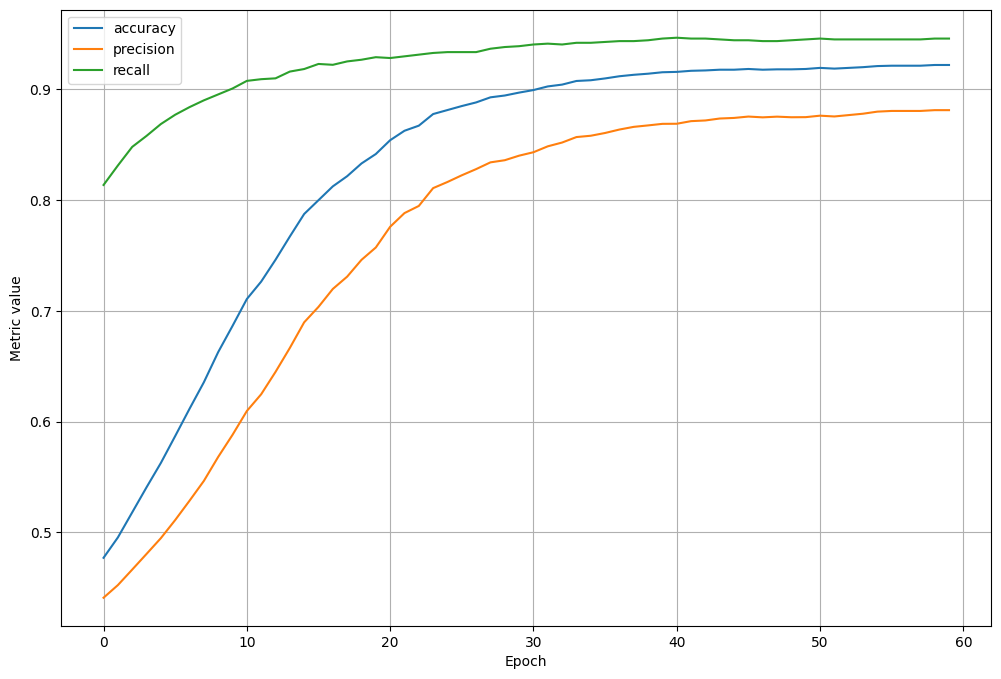

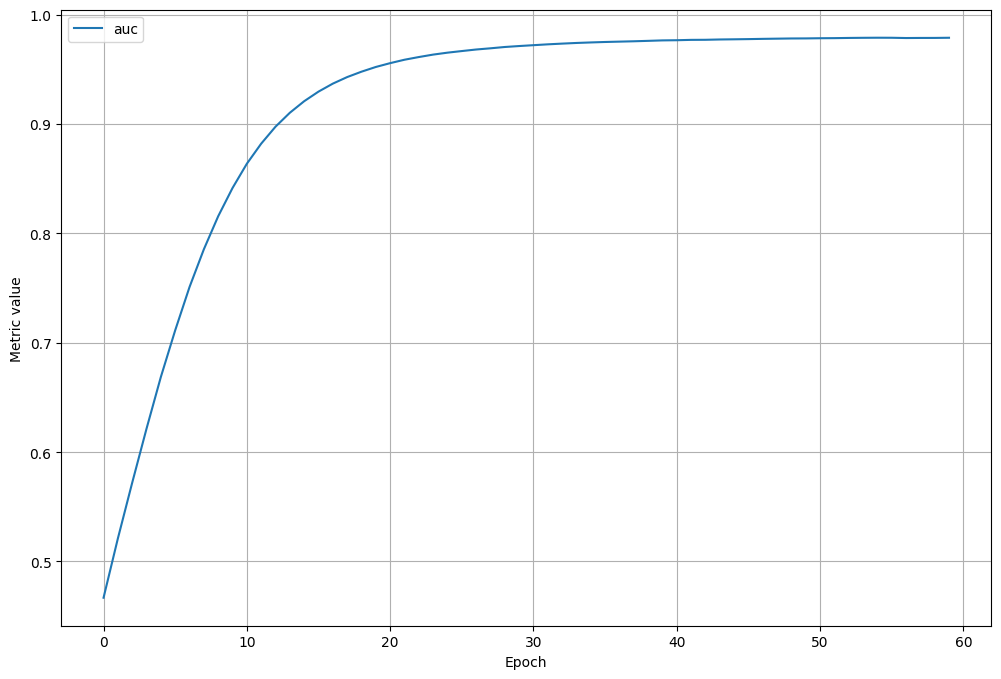

In [30]:
# Let's define our first experiment settings.
settings = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model = create_model(settings, metrics)

# Train the model on the training set.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Plot metrics vs. epochs
plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
plot_experiment_metrics(experiment, ['auc'])

AUC is calculated across all possible thresholds (in practice in the code above, 100 thresholds), while accuracy, precision, and recall are calculated for only the specified threshold. For this reason they are shown separately above.

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [31]:
def evaluate_experiment(
    experiment: Experiment, test_dataset: pd.DataFrame, test_labels: np.array
) -> dict[str, float]:
  features = {
      feature_name: np.array(test_dataset[feature_name])
      for feature_name in experiment.settings.input_features
  }
  return experiment.model.evaluate(
      x=features,
      y=test_labels,
      batch_size=settings.batch_size,
      verbose=0, # Hide progress bar
      return_dict=True,
  )


def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = evaluate_experiment(experiment, test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train accuracy: 0.9219
Test accuracy:  0.9081
------
Train auc: 0.9788
Test auc:  0.9761
------
Train loss: 0.1847
Test loss:  0.1907
------
Train precision: 0.8811
Test precision:  0.8589
------
Train recall: 0.9458
Test recall:  0.9211


It appears that the model, which achieved ~92% accuracy on the training data, still shows an accuracy of about 90% on the test data. Can we do better? Let's train a model using all seven available features and compare the AUC.

In [34]:
# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Convex_Area',
  'Perimeter',
  'Extent',
]

In [ ]:
#@title Solution
# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Convex_Area',
  'Perimeter',
  'Extent',
]

## Train the full-featured model and calculate metrics

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3204 - auc: 0.2448 - loss: 1.2974 - precision: 0.2495 - recall: 0.2794
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3596 - auc: 0.2902 - loss: 1.1836 - precision: 0.2749 - recall: 0.3213 
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3777 - auc: 0.3210 - loss: 1.1163 - precision: 0.2933 - recall: 0.3294
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3874 - auc: 0.3443 - loss: 1.0458 - precision: 0.3029 - recall: 0.3251 
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4476 - auc: 0.4177 - loss: 0.9314 - precision: 0.3570 - recall: 0.3846 
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4924 - auc: 0.4770 - loss: 0.8661 - precision: 0.4168 - recall: 0.4242 
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5464 - auc: 0.5401 - loss: 0.7920 - precision: 0.4775 - recall: 0.4795 
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

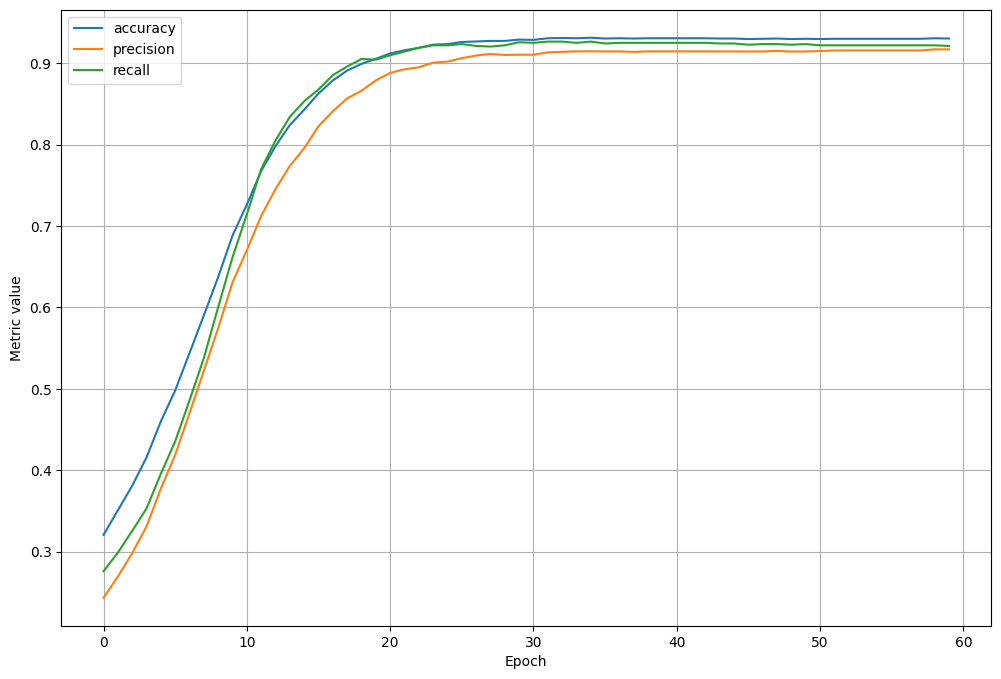

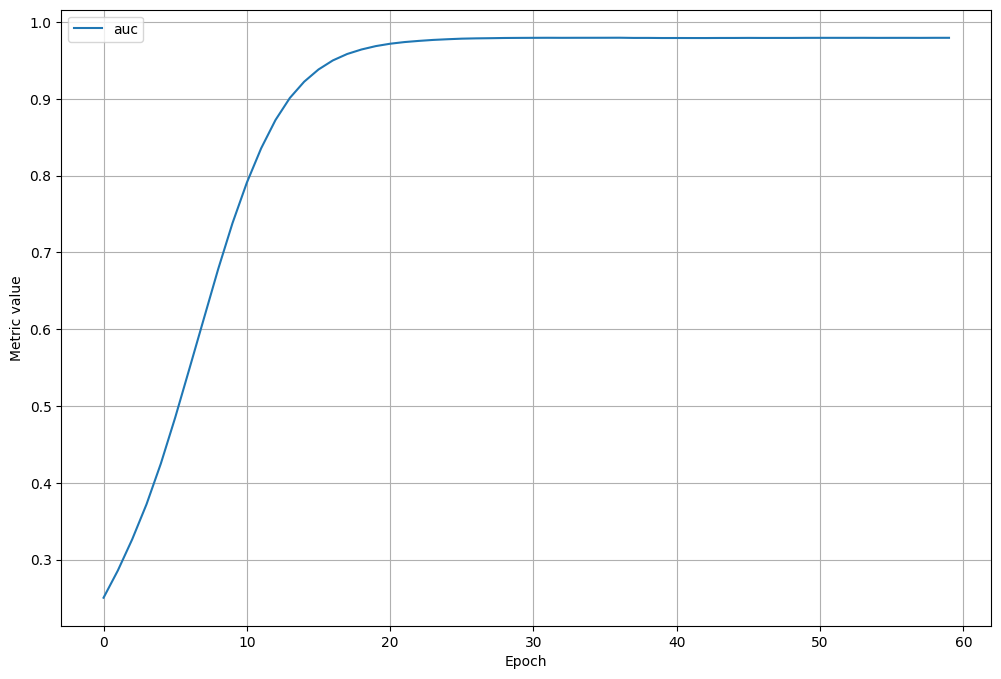

In [35]:
settings_all_features = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5,
    input_features=all_input_features,
)

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings_all_features.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
plot_experiment_metrics(experiment_all_features, ['auc'])

## Evaluate full-featured model on test split

In [36]:
test_metrics_all_features = evaluate_experiment(
    experiment_all_features, test_features, test_labels
)
compare_train_test(experiment_all_features, test_metrics_all_features)

Comparing metrics between train and test:
------
Train accuracy: 0.9304
Test accuracy:  0.9239
------
Train auc: 0.9796
Test auc:  0.9763
------
Train loss: 0.1795
Test loss:  0.1894
------
Train precision: 0.9171
Test precision:  0.9073
------
Train recall: 0.9213
Test recall:  0.9013


This second model has very similar train and test metrics, suggesting it overfit less to the training data.

# Comparing our two models

With our simple experimentation framework, we can keep track of which experiments we ran, and what the results were. We can also define a helper function below which allows us to easily compare two or more models, both during training and when evaluated on the test set.

In [ ]:
#@title Define function to compare experiments

def compare_experiment(experiments: list[Experiment],
                       metrics_of_interest: list[str],
                       test_dataset: pd.DataFrame,
                       test_labels: np.array):
  # Make sure that we have all the data we need.
  for metric in metrics_of_interest:
    for experiment in experiments:
      if metric not in experiment.metrics_history:
        raise ValueError(f'Metric {metric} not available for experiment {experiment.name}')

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(2, 1, 1)

  colors = [f'C{i}' for i in range(len(experiments))]
  markers = ['.', '*', 'd', 's', 'p', 'x']
  marker_size = 10

  ax.set_title('Train metrics')
  for i, metric in enumerate(metrics_of_interest):
    for j, experiment in enumerate(experiments):
      plt.plot(experiment.epochs, experiment.metrics_history[metric], markevery=4,
               marker=markers[i], markersize=marker_size, color=colors[j])

  # Add custom legend to show what the colors and markers mean
  legend_handles = []
  for i, metric in enumerate(metrics_of_interest):
    legend_handles.append(Line2D([0], [0], label=metric, marker=markers[i],
                                 markersize=marker_size, c='k'))
  for i, experiment in enumerate(experiments):
    legend_handles.append(Line2D([0], [0], label=experiment.name, color=colors[i]))

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Metric value")
  ax.grid()
  ax.legend(handles=legend_handles)

  ax = fig.add_subplot(2, 1, 2)
  spacing = 0.3
  n_bars = len(experiments)
  bar_width = (1 - spacing)/n_bars
  for i, experiment in enumerate(experiments):
    test_metrics = evaluate_experiment(experiment, test_dataset, test_labels)
    x = np.arange(len(metrics_of_interest)) + bar_width * (i + 1/2 - n_bars/2)
    ax.bar(x, [test_metrics[metric] for metric in metrics_of_interest], width=bar_width, label=experiment.name)
  ax.set_xticks(np.arange(len(metrics_of_interest)), metrics_of_interest)

  ax.set_title('Test metrics')
  ax.set_ylabel('Metric value')
  ax.set_axisbelow(True) # Put the grid behind the bars
  ax.grid()
  ax.legend()

print('Defined function to compare experiments.')

In [ ]:
compare_experiment([experiment, experiment_all_features],
                   ['accuracy', 'auc'],
                   test_features, test_labels)

Comparing the two models, both have AUC of ~.97-.98. There does not seem to be a large gain in model quality when adding the other four features, which makes sense, given that many of the features (area, perimeter, and convex area, for example) are interrelated.